In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, Birch, AffinityPropagation
# from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import os
from yellowbrick.cluster import KElbowVisualizer

In [2]:
df = pd.read_csv('csv/new_data.csv', index_col=0)

In [3]:
private = df.copy(['name', 'mail', 'IP', 'dt_completion', 't_used'])
df = df.drop(['name', 'mail', 'IP', 'dt_completion', 't_used'], axis=1)

In [4]:
scaler = MinMaxScaler()
normalized_answers = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
scaled_ans = normalized_answers.values
pca = PCA(n_components=12)
selected_features = pca.fit_transform(scaled_ans)

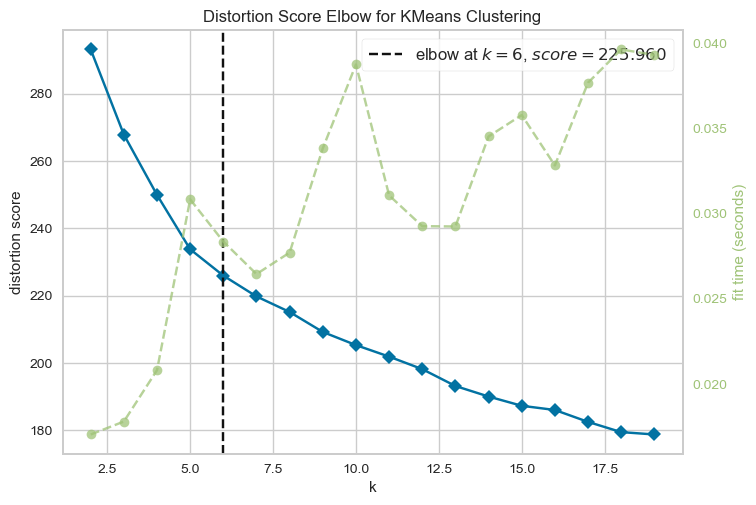

In [5]:
model = KMeans()

visualizer = KElbowVisualizer(model, k=(2,20), timings= True)
visualizer.fit(selected_features)
visualizer.show()
k_n1 = visualizer.elbow_value_

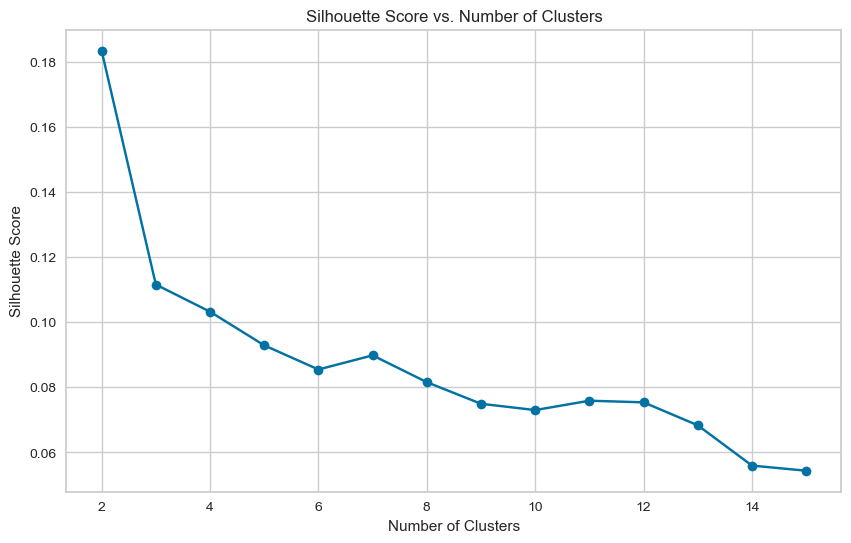

In [6]:
max_clusters = 15

silhouette_scores = []
for n_clusters in range(2, max_clusters + 1):
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    labels = clustering.fit_predict(selected_features)
    score = silhouette_score(selected_features, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

<Figure size 1200x600 with 0 Axes>

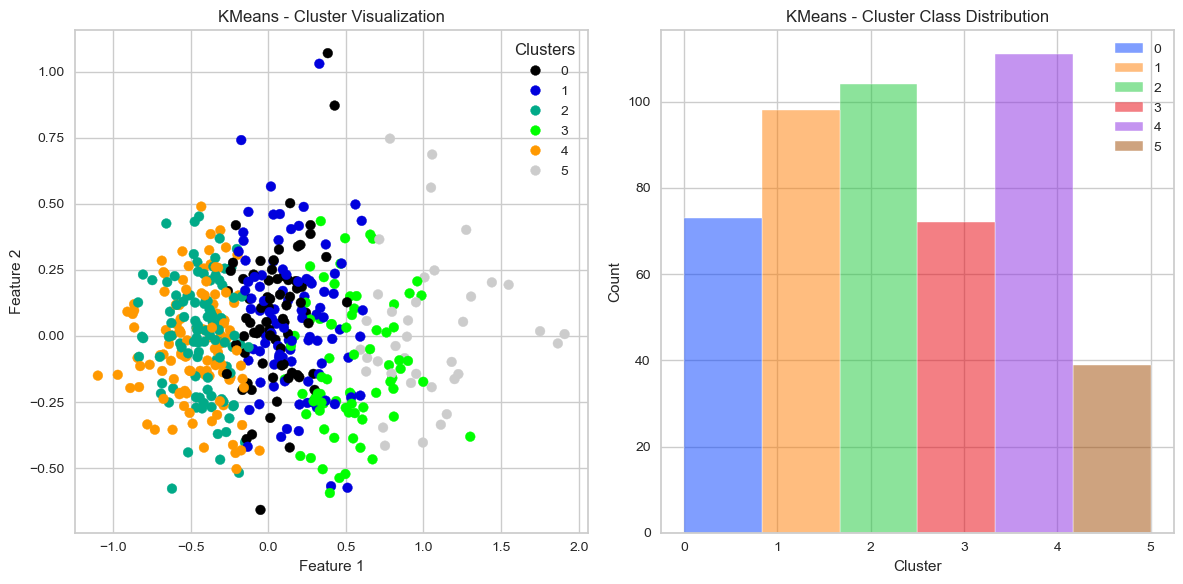

<Figure size 1200x600 with 0 Axes>

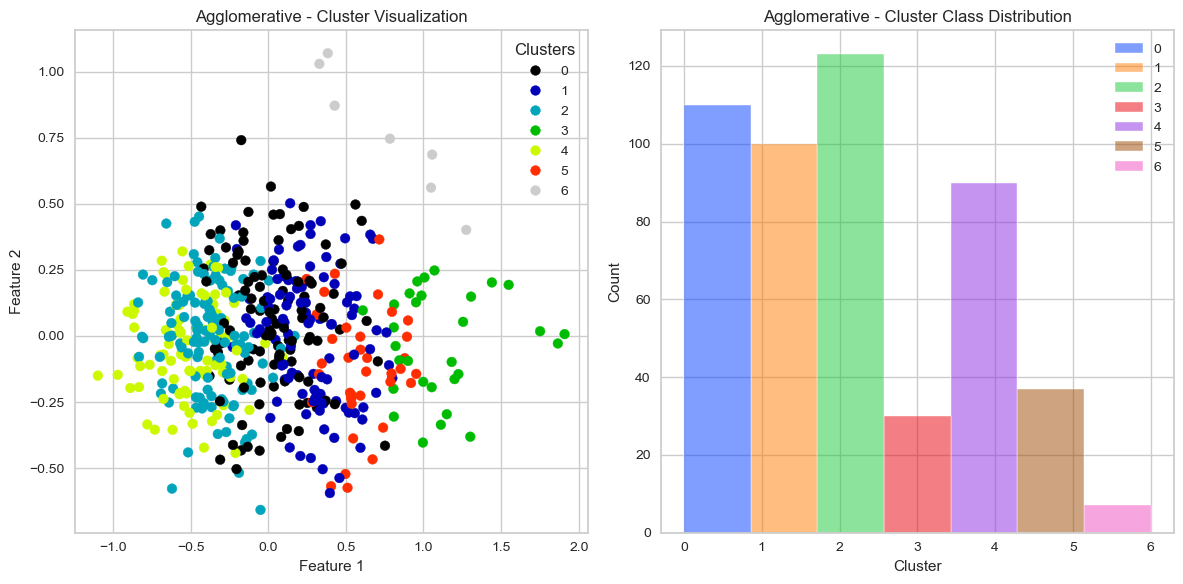

<Figure size 1200x600 with 0 Axes>

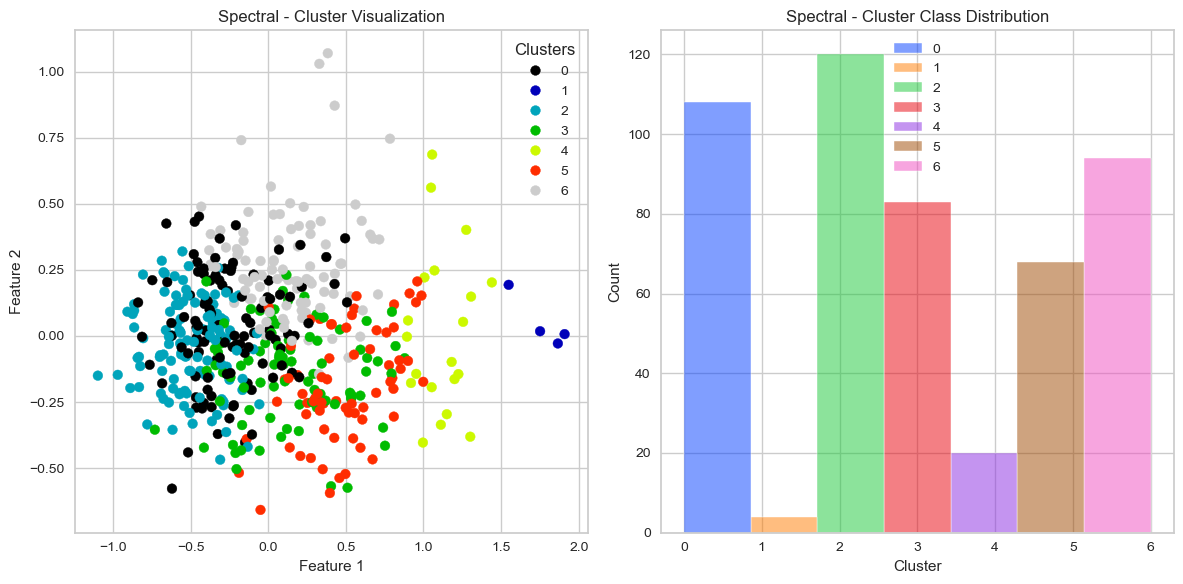

<Figure size 1200x600 with 0 Axes>

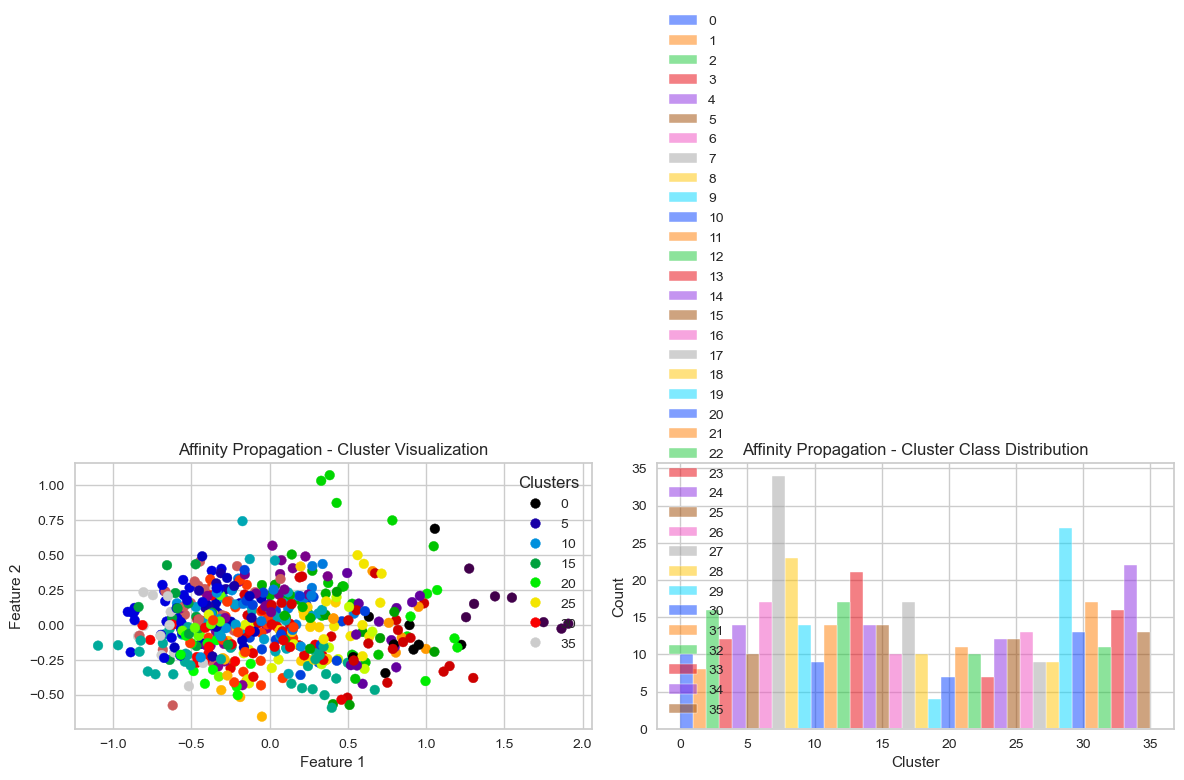

In [7]:
clustering_methods = [
    KMeans(n_clusters=k_n1),
    AgglomerativeClustering(n_clusters=7),
    SpectralClustering(n_clusters=7),
    AffinityPropagation(),
]

method_names = [
    'KMeans',
    'Agglomerative',
    'Spectral',
    'Affinity Propagation',
]

silhouette_scores = []
calinski_scores = []
davies_bouldin_scores = []

for i, method in enumerate(clustering_methods):

    cluster_labels = method.fit_predict(selected_features)
    silhouette_scores.append(silhouette_score(selected_features, cluster_labels))
    calinski_scores.append(calinski_harabasz_score(selected_features, cluster_labels))
    davies_bouldin_scores.append(davies_bouldin_score(selected_features, cluster_labels))

    if method_names[i] == 'KMeans':
        df['KMeans_labels'] = cluster_labels
    elif method_names[i] == 'Agglomerative':
        df['Agglomerative_labels'] = cluster_labels

    fig = plt.figure(figsize=(12, 6))

    fig = plt.figure(figsize=(12, 6))

    ax1 = fig.add_subplot(121)
    scatter = ax1.scatter(selected_features[:, 0], selected_features[:, 2],
                          c=cluster_labels, cmap='nipy_spectral')
    ax1.set_title(f'{method_names[i]} - Cluster Visualization')
    ax1.set_xlabel('Feature 1')
    ax1.set_ylabel('Feature 2')
    ax1.legend(*scatter.legend_elements(), title='Clusters')

    ax2 = fig.add_subplot(122)
    sns.histplot(x=cluster_labels, bins=len(np.unique(cluster_labels)), kde=False, ax=ax2, hue=cluster_labels,  palette='bright', )
    ax2.set_title(f'{method_names[i]} - Cluster Class Distribution')
    ax2.set_xlabel('Cluster')
    ax2.set_ylabel('Count')

    plt.tight_layout()
    plt.savefig(f'img/initial_ds/{method_names[i]}_clusters_2D.png', dpi=300)
    plt.show()

silhouette_scores = [f"{score:.4f}" for score in silhouette_scores]
calinski_scores = [f"{score:.4f}" for score in calinski_scores]
davies_bouldin_scores = [f"{score:.4f}" for score in davies_bouldin_scores]

evaluation_df = pd.DataFrame({
    'Method': method_names,
    'Silhouette Score': silhouette_scores,
    'Calinski-Harabasz Score': calinski_scores,
    'Davies-Bouldin Score': davies_bouldin_scores
})

In [8]:
def normalize_values(values):
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_values = scaler.fit_transform(values.flatten().reshape(-1, 1))

    return normalized_values.reshape(values.shape)

def generate_cluster_heatmaps(df, method, save_filename=None):

    section_numbers = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12']
    section_order = sorted(section_numbers, key=lambda x: int(x[1:]))

    if method == 'KMeans':
        indd = 'KMeans_labels'
    else:
        indd = 'Agglomerative_labels'

    cluster_corr = df.pivot_table(index=indd, columns=None, values=section_numbers, aggfunc='mean')

    cluster_corr = cluster_corr[section_order]

    normalized_cluster_corr = normalize_values(cluster_corr.values)
    normalized_cluster_corr = pd.DataFrame(normalized_cluster_corr, index=cluster_corr.index, columns=cluster_corr.columns)

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(normalized_cluster_corr, cmap='plasma', annot=True, fmt=".1f", linewidths=0.5)
    plt.title('Cluster Labels Correlation with Section Results - {method.capitalize()}', fontsize=16)
    plt.xlabel('Section Numbers')
    plt.ylabel('Cluster Labels')

    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va="center")
    ax.set_yticklabels([str(int(label.get_text()) + 1) for label in ax.get_yticklabels()])

    plt.tight_layout()
    if save_filename:
        plt.savefig(save_filename, dpi=400)
    plt.show()

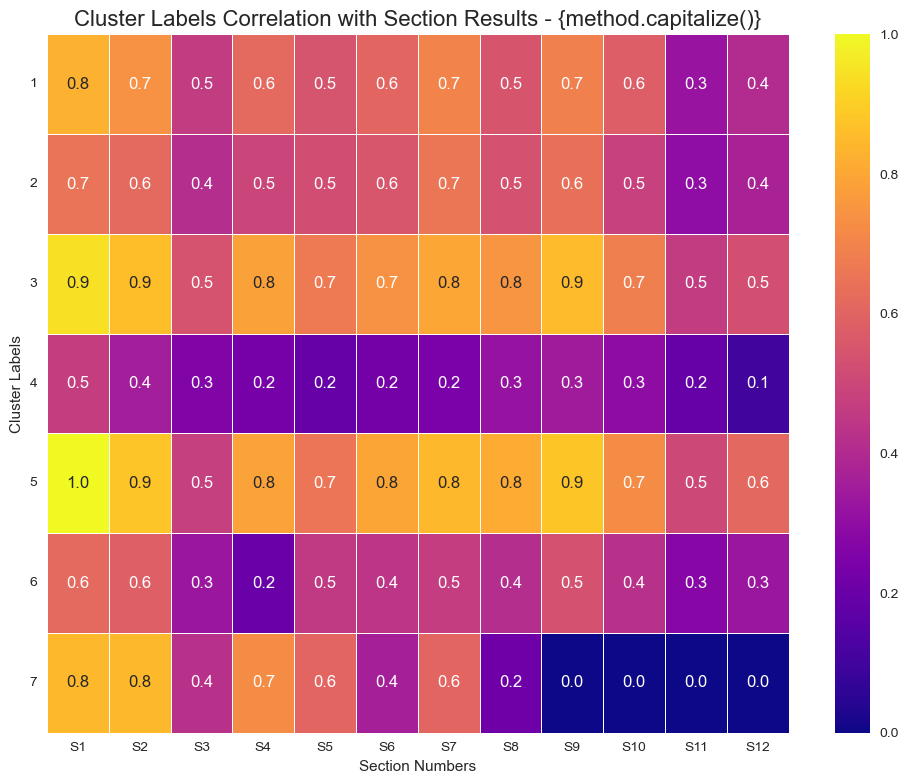

In [9]:
generate_cluster_heatmaps(df, method='Agglomerative', save_filename='agg_heatmap.png')

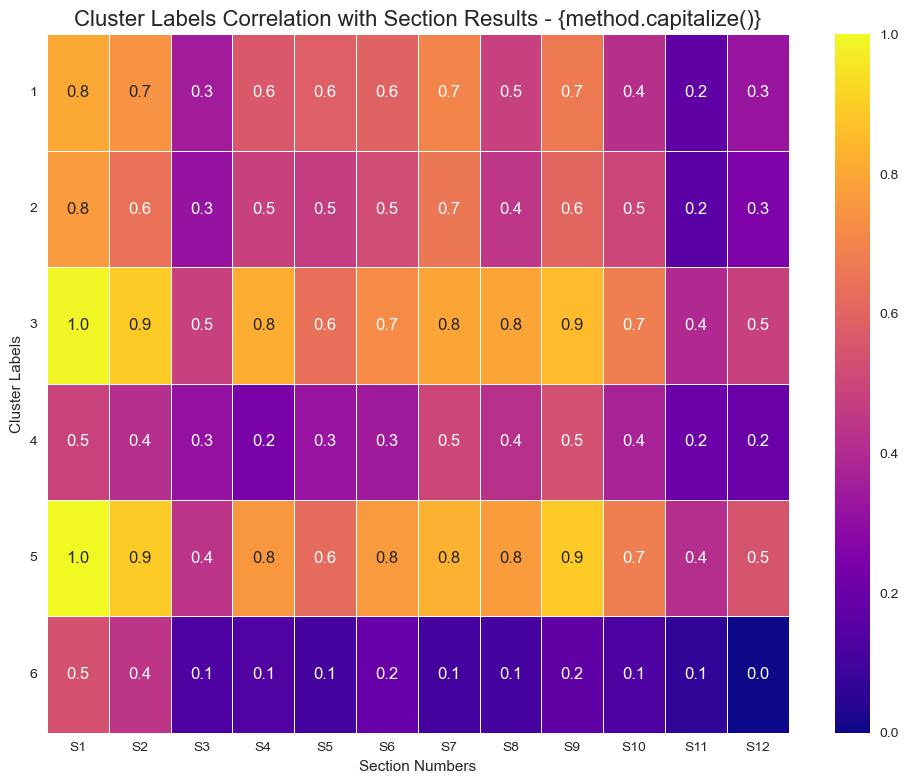

In [10]:
generate_cluster_heatmaps(df, method='KMeans', save_filename='k_heatmap.png')